All code generated from ChatGPT 4

In [1]:
# pip install torch torchvision scikit-learn matplotlib

import os, glob, math, random
from PIL import Image
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [14]:
## Data loader ##

#IMG_H, IMG_W = 128, 192
IMG_H, IMG_W = 64, 96
BATCH_SIZE = 128
LATENT_DIM = 32      # small & factorized; try 8–32
BETA = 1.0           # β-VAE: >1 encourages disentanglement
EPOCHS = 1000
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def ensure_rgb(im):
        return im.convert("RGBA").convert("RGB") if im.mode != "RGB" else im

class PixelPortraits(Dataset):
    
    def __init__(self, root):
        self.files = sorted([p for p in glob.glob(os.path.join(root, "*")) 
                             if p.lower().endswith((".png",".jpg",".jpeg",".bmp",".webp"))])
        # Keep pixel edges sharp

        self.t = transforms.Compose([
            transforms.Lambda(ensure_rgb),
            transforms.Resize((IMG_H, IMG_W), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
        ])
        
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        im = Image.open(self.files[i])
        return self.t(im)

ds = PixelPortraits("training_data")
#dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
len(ds)

72

In [15]:
## Data encoder/decoder and VAE ##
import torch
from torch import nn
import torch.nn.functional as F

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        ch = 64
        self.conv = nn.Sequential(
            nn.Conv2d(3, ch, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(ch, ch*2, 4, 2, 1), nn.BatchNorm2d(ch*2), nn.ReLU(True),
            nn.Conv2d(ch*2, ch*4, 4, 2, 1), nn.BatchNorm2d(ch*4), nn.ReLU(True),
            nn.Conv2d(ch*4, ch*8, 4, 2, 1), nn.BatchNorm2d(ch*8), nn.ReLU(True)
        )
        self.mu = None
        self.logvar = None
        self.flattened_size = None
        self.enc_shape = None
        self.z_dim = z_dim

    def build(self, input_shape):
        """Run once with dummy data to build Linear layers dynamically"""
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            h = self.conv(dummy)
            self.flattened_size = h.numel() // h.shape[0]
            self.enc_shape = h.shape[1:]
        self.mu = nn.Linear(self.flattened_size, self.z_dim)
        self.logvar = nn.Linear(self.flattened_size, self.z_dim)

    def forward(self, x):
        h = self.conv(x)
        h_flat = h.view(x.size(0), -1)
        mu = self.mu(h_flat)
        logvar = self.logvar(h_flat)
        logvar = torch.clamp(logvar, min=-10, max=10)  # keeps exp(logvar) reasonable
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, z_dim, flattened_size, enc_shape):
        super().__init__()
        ch = 64
        self.fc = nn.Linear(z_dim, flattened_size)
        C, H, W = enc_shape
        self.enc_shape = enc_shape

        self.net = nn.Sequential(
            nn.ConvTranspose2d(ch*8, ch*4, 4, 2, 1), nn.BatchNorm2d(ch*4), nn.ReLU(True),
            nn.ConvTranspose2d(ch*4, ch*2, 4, 2, 1), nn.BatchNorm2d(ch*2), nn.ReLU(True),
            nn.ConvTranspose2d(ch*2, ch, 4, 2, 1), nn.BatchNorm2d(ch), nn.ReLU(True),
            nn.ConvTranspose2d(ch, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, z):
        h = self.fc(z).view(z.size(0), *self.enc_shape)
        return self.net(h)


class VAE(nn.Module):
    def __init__(self, z_dim, input_shape):
        super().__init__()
        self.enc = Encoder(z_dim)
        self.enc.build(input_shape)   # dynamically build FC layers
        self.dec = Decoder(z_dim, self.enc.flattened_size, self.enc.enc_shape)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.enc(x)
        z = self.reparam(mu, logvar)
        xhat = self.dec(z)
        return xhat, mu, logvar, z


# ---- losses ----
def mse_loss(x, xhat):
    return F.mse_loss(xhat, x, reduction="mean")

def kl_divergence(mu, logvar):
    return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar, dim=1).mean()

def kl_weight(epoch, total_epochs, max_beta=BETA, start_pct=0.1):
    start = int(total_epochs * start_pct)
    if epoch < start: return 0.0
    t = (epoch - start) / max(1, total_epochs - start)
    return float(max_beta) * float(min(1.0, t))

In [64]:
model = VAE(LATENT_DIM, INPUT_SHAPE).to(DEVICE)
x = torch.randn(2, *INPUT_SHAPE).to(DEVICE)
xhat, mu, logvar, z = model(x)
print("x shape:", x.shape)
print("xhat shape:", xhat.shape)

x shape: torch.Size([2, 3, 64, 96])
xhat shape: torch.Size([2, 3, 64, 96])


In [16]:
## Training loop and snapshots ##

import torch
import torch.optim as optim
from torchvision.utils import make_grid, save_image
import os

# ---- params ----
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs("runs/vae", exist_ok=True)

# ---- assume `dl` is your DataLoader and `ds` is your Dataset ----
# get input shape from first batch dynamically
batch = next(iter(dl))
input_shape = batch.shape[1:]  # (C,H,W)
LATENT_DIM = 64

# ---- instantiate model ----
model = VAE(LATENT_DIM, input_shape).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR)

# ---- losses ----
def recon_loss(x, xhat):
    return torch.nn.functional.mse_loss(xhat, x, reduction='mean')

def kl_divergence(mu, logvar):
    return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar, dim=1).mean()

def kl_weight(epoch, total_epochs, max_beta=BETA, start_pct=0.05):
    start = int(total_epochs * start_pct)
    if epoch < start: return 0.0
    t = (epoch - start) / max(1, (total_epochs - start))
    return float(max_beta) * float(min(1.0, t))

@torch.no_grad()
def preview_batch(x, xhat, epoch):
    # concatenate input and reconstruction
    n = min(8, x.size(0))
    grid = make_grid(torch.cat([x[:n], xhat[:n]], dim=0), nrow=n)
    save_image(grid, f"runs/vae/recon_e{epoch:03d}.png")

# ---- training loop ----
for epoch in range(1, EPOCHS+1):
    model.train()
    total_recon, total_kl = 0.0, 0.0
    lam = kl_weight(epoch, EPOCHS, BETA)

    for x in dl:
        x = x.to(DEVICE)
        xhat, mu, logvar, _ = model(x)
        r = recon_loss(x, xhat)
        kl = kl_divergence(mu, logvar)
        loss = r + lam * kl

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_recon += r.item() * x.size(0)
        total_kl += kl.item() * x.size(0)

    print(f"Epoch {epoch:3d} | recon {total_recon/len(ds):.4f} | KL {total_kl/len(ds):.4f} | β {lam:.2f}")

    # quick preview
    model.eval()
    with torch.no_grad():
        sample = next(iter(dl)).to(DEVICE)
        xhat, *_ = model(sample)
        preview_batch(sample, xhat, epoch)

torch.save(model.state_dict(), "runs/vae/vae.pt")

Epoch   1 | recon 0.1140 | KL 8.5804 | β 0.00
Epoch   2 | recon 0.1086 | KL 18.9378 | β 0.00
Epoch   3 | recon 0.1032 | KL 46.4259 | β 0.00
Epoch   4 | recon 0.0862 | KL 400.1510 | β 0.00
Epoch   5 | recon 0.0801 | KL 544.1260 | β 0.00
Epoch   6 | recon 0.0796 | KL 682.7214 | β 0.00
Epoch   7 | recon 0.0779 | KL 695.3850 | β 0.00
Epoch   8 | recon 0.0776 | KL 747.4536 | β 0.00
Epoch   9 | recon 0.0760 | KL 838.2485 | β 0.00
Epoch  10 | recon 0.0759 | KL 846.9832 | β 0.00
Epoch  11 | recon 0.0749 | KL 853.4700 | β 0.00
Epoch  12 | recon 0.0745 | KL 863.2025 | β 0.00
Epoch  13 | recon 0.0729 | KL 877.6003 | β 0.00
Epoch  14 | recon 0.0723 | KL 894.2219 | β 0.00
Epoch  15 | recon 0.0707 | KL 917.5864 | β 0.00
Epoch  16 | recon 0.0699 | KL 944.4520 | β 0.00
Epoch  17 | recon 0.0690 | KL 977.5586 | β 0.00
Epoch  18 | recon 0.0673 | KL 1018.8536 | β 0.00
Epoch  19 | recon 0.0671 | KL 1059.3962 | β 0.00
Epoch  20 | recon 0.0647 | KL 1108.7548 | β 0.00
Epoch  21 | recon 0.0640 | KL 1161.7882 |

In [5]:
## Extract latent code from dataset ##

@torch.no_grad()
def encode_dataset(model, loader):
    model.eval()
    zs, mus, logvars = [], [], []
    for x in loader:
        x = x.to(DEVICE)
        _, mu, logvar, z = model(x)
        zs.append(z.cpu())
        mus.append(mu.cpu())
        logvars.append(logvar.cpu())
    return torch.cat(zs), torch.cat(mus), torch.cat(logvars)

Z, MU, LOGVAR = encode_dataset(model, dl)   # [N, LATENT_DIM]
Z.shape

torch.Size([72, 64])

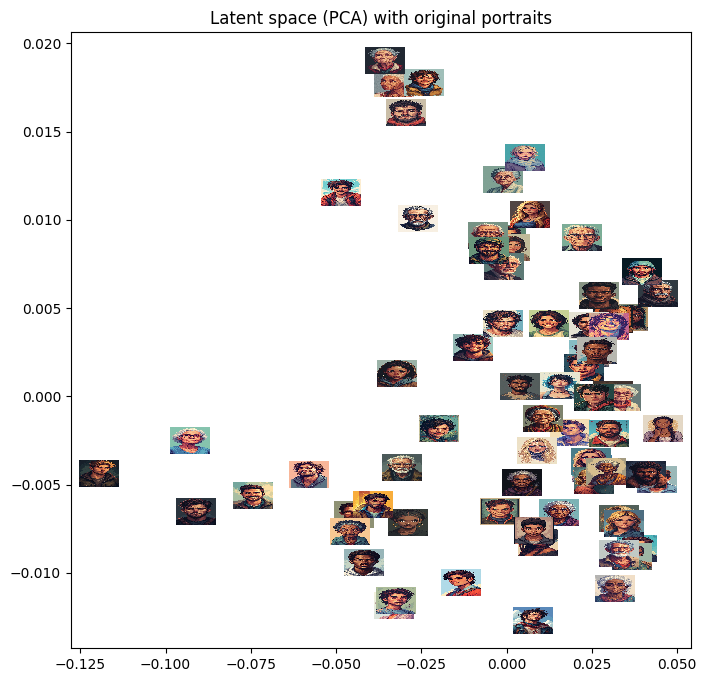

In [7]:
## Visualise latent space ##
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import numpy as np

# 1. Reduce latent means to 2D
pca2 = PCA(n_components=2)
Z2 = pca2.fit_transform(MU.numpy())

# 2. Pick subset if dataset is large
n_show = min(500, len(Z2))
idxs = np.random.choice(len(Z2), n_show, replace=False)
Z_plot = Z2[idxs]

# 3. Get original images from dataset
orig_imgs = [np.transpose(ds[i].numpy(), (1,2,0)) for i in idxs]  # HWC in [0,1]

# 4. Plot
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Latent space (PCA) with original portraits")
ax.scatter(Z_plot[:,0], Z_plot[:,1], alpha=0.0)  # invisible anchor points

for xy, im in zip(Z_plot, orig_imgs):
    imbox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(im, zoom=0.3, interpolation="nearest"),  # nearest keeps pixel-art sharp
        xy,
        frameon=False
    )
    ax.add_artist(imbox)

plt.show()

In [9]:
## PCA over latents ##

# Full PCA on latent means
pca = PCA(n_components=LATENT_DIM)
Zp = pca.fit_transform(MU.numpy())     # projected coords
components = pca.components_           # [k, LATENT_DIM]
explained = pca.explained_variance_ratio_

print("Top PCs explained variance:", explained[:5])

@torch.no_grad()
def decode_traversal(model, z0, direction, steps=9, width=2.0):
    # z(t) = z0 + t * dir, t in linspace(-width, width)
    ts = np.linspace(-width, width, steps)
    imgs = []
    d = torch.tensor(direction, dtype=torch.float32, device=DEVICE)
    d = d / (d.norm() + 1e-8)
    for t in ts:
        z = torch.tensor(z0, dtype=torch.float32, device=DEVICE) + float(t)*d
        im = model.dec(z.unsqueeze(0)).clamp(0,1)
        imgs.append(im)
    return torch.cat(imgs, dim=0)

# Pick an example portrait
x0 = next(iter(dl))[:1].to(DEVICE)
_, mu0, _, _ = model(x0)
z0 = mu0[0].detach().cpu().numpy()

# Traverse the first principal component
pc_idx = 0
dir_pc1 = components[pc_idx]          # direction in latent space
grid = decode_traversal(model, z0, dir_pc1, steps=11, width=3.0)
save_image(utils.make_grid(grid, nrow=11), "runs/vae/traverse_pc1.png")

# Traverse the second principal component
pc_idx = 1
dir_pc1 = components[pc_idx]          # direction in latent space
grid = decode_traversal(model, z0, dir_pc1, steps=11, width=3.0)
save_image(utils.make_grid(grid, nrow=11), "runs/vae/traverse_pc2.png")

# Traverse the third principal component
pc_idx = 2
dir_pc1 = components[pc_idx]          # direction in latent space
grid = decode_traversal(model, z0, dir_pc1, steps=11, width=3.0)
save_image(utils.make_grid(grid, nrow=11), "runs/vae/traverse_pc3.png")

# Traverse the fourth principal component
pc_idx = 3
dir_pc1 = components[pc_idx]          # direction in latent space
grid = decode_traversal(model, z0, dir_pc1, steps=11, width=3.0)
save_image(utils.make_grid(grid, nrow=11), "runs/vae/traverse_pc4.png")

# Traverse the fifth principal component
pc_idx = 4
dir_pc1 = components[pc_idx]          # direction in latent space
grid = decode_traversal(model, z0, dir_pc1, steps=11, width=3.0)
save_image(utils.make_grid(grid, nrow=11), "runs/vae/traverse_pc5.png")

# Try PC2, PC3… adjust width until changes are meaningful but not destructive

Top PCs explained variance: [0.74208623 0.03589277 0.01524293 0.01420433 0.01345933]


In [12]:
## Latent arithmetic

@torch.no_grad()
def latent_add(model, z_a, z_b, z_c):
    # (A_has_trait - A_no_trait) + C_no_trait ⇒ C_with_trait
    z_new = z_a - z_b + z_c
    return model.dec(z_new.unsqueeze(0)).clamp(0,1)

# Suppose you’ve identified three images by index:
idx_A_has, idx_A_no, idx_C_no = 0, 1, 2
# Get their latent means
def latent_mu_by_index(i):
    # Resample single image deterministically by mean
    x = ds[i].unsqueeze(0).to(DEVICE)
    _, mu, _, _ = model(x)
    return mu[0]

zA_has = latent_mu_by_index(idx_A_has)
zA_no  = latent_mu_by_index(idx_A_no)
zC_no  = latent_mu_by_index(idx_C_no)

img_arith = latent_add(model, zA_has, zA_no, zC_no)
save_image(img_arith, "runs/vae/latent_arithmetic.png")


# Move +2 std along PC1 for sample i, then decode
i = 5
z0 = MU[i].numpy()
pc = components[0]
delta = 2.0 * pc / (np.linalg.norm(pc) + 1e-8)
with torch.no_grad():
    z_shift = torch.tensor(z0 + delta, dtype=torch.float32, device=DEVICE)
    img = model.dec(z_shift.unsqueeze(0)).clamp(0,1)
save_image(img, "runs/vae/pc1_plus2std.png")

In [13]:
## Interpolation

@torch.no_grad()
def interpolate(model, z_a, z_b, steps=9):
    imgs = []
    for t in np.linspace(0,1,steps):
        z = (1-t)*z_a + t*z_b
        im = model.dec(z.unsqueeze(0)).clamp(0,1)
        imgs.append(im)
    return torch.cat(imgs, dim=0)

ia, ib = 3, 17
za = MU[ia].to(DEVICE)
zb = MU[ib].to(DEVICE)
grid = interpolate(model, za, zb, steps=11)
save_image(utils.make_grid(grid, nrow=11), "runs/vae/interp_a_to_b.png")